# Redo P-fix

with the surface fluxes problem fixed we want to have a new look at the difference between the two setups: *p-fix* and *rho-fix*:

![](img/fig_all_domain_means_twowarmings.png)

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import subprocess as sup

def latbc_script_body(warming_function, in_directory, out_directory, match_keywords, 
                      division=False, temperatures=(304,300)):
    return f'''
def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    print(d[varnames['temperature']].values, flush=True) #db
    d = {warming_function}(d, varnames=varnames)
    print(d[varnames['temperature']].values, flush=True) #db
    d.to_netcdf(ofile)
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
latbc_files = list_files(IN_DIRECTORY, {match_keywords})
if division: latbc_files = sublist(latbc_files, division[0], division[1])

# In case of a failed script, I want to know in details what script to relaunch
# therefore here comes some printout
print('latbc_script', flush=True)
print('IN_DIRECTORY: ', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY: ', OUT_DIRECTORY, flush=True)
print('division: ', division, flush=True)
for f in latbc_files: print(f, flush=True)
print('', flush=True)

# make sure directory structure is there
create_directory_structure(latbc_files, OUT_DIRECTORY)
# Compile arguments
varnames = get_varnames({{"pressure" : "pres", "temperature" : "temp"}})
args_list = list()
for f in latbc_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile, ofile, varnames))

# Do the work
for args in args_list:
    print(args, flush=True)
    warm_atmospheric_profile(*args)

print('done', flush=True)
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    sup.call(['sbatch', name])
    try_remove(name)

def launch_latbc_scripts(in_directory='/work/mh1126/m300872/unchanged/', 
                         out_directory='/work/mh1126/m300872/test/',
                         warming_function = 'apply_warming_rho_fixed',
                         keywords = ['latbc', 'PR1250m_DOM01', '.nc'],
                         n_scripts=100):
    for script_id in range(n_scripts):
        division=(n_scripts, script_id)
        script = create_latbc_script(in_directory, out_directory, warming_function, keywords, division)
        launch_script(script)
        
def create_latbc_script(in_directory='/work/mh1126/m300872/unchanged/', 
                        out_directory='/work/mh1126/m300872/test/', 
                        warming_function='apply_warming_rho_fixed', 
                        keywords=['latbc', 'PR1250m_DOM01', '.nc'], 
                        division=None, verbose=False):
    if verbose: 
        latbc_files = fh.list_files(in_directory, keywords)
        print(division)
        if not division == None: latbc_files = fh.sublist(latbc_files, division[0], division[1])
        for f in latbc_files: print('  ', f)
    script = fh.slurm_header(10, log_path=out_directory) + fh.some_module_files() + \
             latbc_script_body(warming_function, in_directory, out_directory, keywords, division=division)
    return script

in_directory  = '/work/mh1126/m300872/unchanged/'
out_directory = '/work/mh1126/m300872/moist_adiabatic_pfix/'
warming_function = 'apply_warming_p_fixed'
keywords = ['latbc', 'PR1250m_DOM01', '.nc']

# launch all scripts
launch_latbc_scripts(in_directory, out_directory, warming_function, keywords, n_scripts=100)
# # relaunch of failed scripts (i receive emails for failed scripts):
# for division in [(1000, 0)]:
#     script = create_latbc_script(in_directory, out_directory, warming_function, keywords, division, verbose=True)
#     launch_script(script)

Submitted batch job 8136206
Submitted batch job 8136207
Submitted batch job 8136208
Submitted batch job 8136209
Submitted batch job 8136210
Submitted batch job 8136211
Submitted batch job 8136212
Submitted batch job 8136213
Submitted batch job 8136214
Submitted batch job 8136215
Submitted batch job 8136216
Submitted batch job 8136217
Submitted batch job 8136218
Submitted batch job 8136219
Submitted batch job 8136220
Submitted batch job 8136221
Submitted batch job 8136222
Submitted batch job 8136223
Submitted batch job 8136224
Submitted batch job 8136225
Submitted batch job 8136226
Submitted batch job 8136227
Submitted batch job 8136228
Submitted batch job 8136229
Submitted batch job 8136230
Submitted batch job 8136231
Submitted batch job 8136232
Submitted batch job 8136233
Submitted batch job 8136234
Submitted batch job 8136235
Submitted batch job 8136236
Submitted batch job 8136237
Submitted batch job 8136238
Submitted batch job 8136239
Submitted batch job 8136240
Submitted batch job 

In [33]:
def initc_script_body(in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/test/',
                      warming_function='apply_warming_rho_fixed'):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
initc_files = [os.path.join('initc',f) for f in list_files(os.path.join(IN_DIRECTORY, 'initc'))]
create_directory_structure(initc_files, OUT_DIRECTORY)

for f in initc_files: print(f, flush=True)
print('', flush=True)

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = {warming_function}(d, varnames=varnames)
    d = add_prognostic_variables(d, varnames=varnames)
    d.to_netcdf(ofile)

initcon_varnames = dict()
initcon_varnames["pressure"] = "p"
initcon_varnames["temperature"] = "t"
varnames = get_varnames(initcon_varnames)
print(varnames, flush=True)
print('', flush=True)

ifile = os.path.join(IN_DIRECTORY,initc_files[0])
ofile = os.path.join(OUT_DIRECTORY,initc_files[0])
warm_atmospheric_profile(ifile, ofile, varnames)
print('done', flush=True)
'''

def launch_initc_script(in_directory='/work/mh1126/m300872/unchanged/',
                        out_directory='/work/mh1126/m300872/test/',
                        warming_function='apply_warming_rho_fixed'):
    script = fh.slurm_header(10) + fh.some_module_files() + \
             initc_script_body(in_directory, out_directory, warming_function)
    launch_script(script)

    
in_directory='/work/mh1126/m300872/unchanged/'
out_directory='/work/mh1126/m300872/moist_adiabatic_pfix/'
warming_function='apply_warming_p_fixed'

launch_initc_script(in_directory, out_directory, warming_function)

Submitted batch job 8056386


In [34]:
import subprocess as sup

def sstsic_script_body(division=False, 
                      in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/moist_adiabatic_pfix/',
                      temperatures=(300,304)):
    return f'''
import netCDF4 as nc
import xarray as xr
import subprocess as sup

IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
temperatures = {temperatures}

print(division)
sstsic_files = list_files(os.path.join(IN_DIRECTORY, 'sst_sic'), ['sst_sic_DOM0'])
sstsic_files = [os.path.join('sst_sic',f) for f in sstsic_files if f.endswith('.nc')]
if division: sstsic_files = sublist(sstsic_files, division[0], division[1])
create_directory_structure(sstsic_files, OUT_DIRECTORY)
    
# pack arguments
delta = temperatures[1] - temperatures[0]
args_list = list()
for f in sstsic_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,delta))

for args in args_list:
    # copy original file, then overwrite SST timestepwise (file to big to write at once)
    (ifile, ofile, delta) = args
    sup.call(['cp', ifile, ofile])
    time_shape = xr.open_dataset(ifile).time.values.shape
    with nc.Dataset(args[1], mode='a') as fp:
        for i in range(time_shape[0]):
            chunk = xr.open_dataset(ifile)['SST'].isel(time=i).values + delta
            fp['SST'][i] = chunk
            
print('done', flush=True)
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    sup.call(['sbatch', name])
    try_remove(name)

def launch_sstsic_script(n_scripts=3):
    for script_id in range(n_scripts):
        script = fh.slurm_header(15) + fh.some_module_files() + \
                 sstsic_script_body(division=(n_scripts, script_id))
        launch_script(script)


launch_sstsic_script()

Submitted batch job 8056398
Submitted batch job 8056399
Submitted batch job 8056400


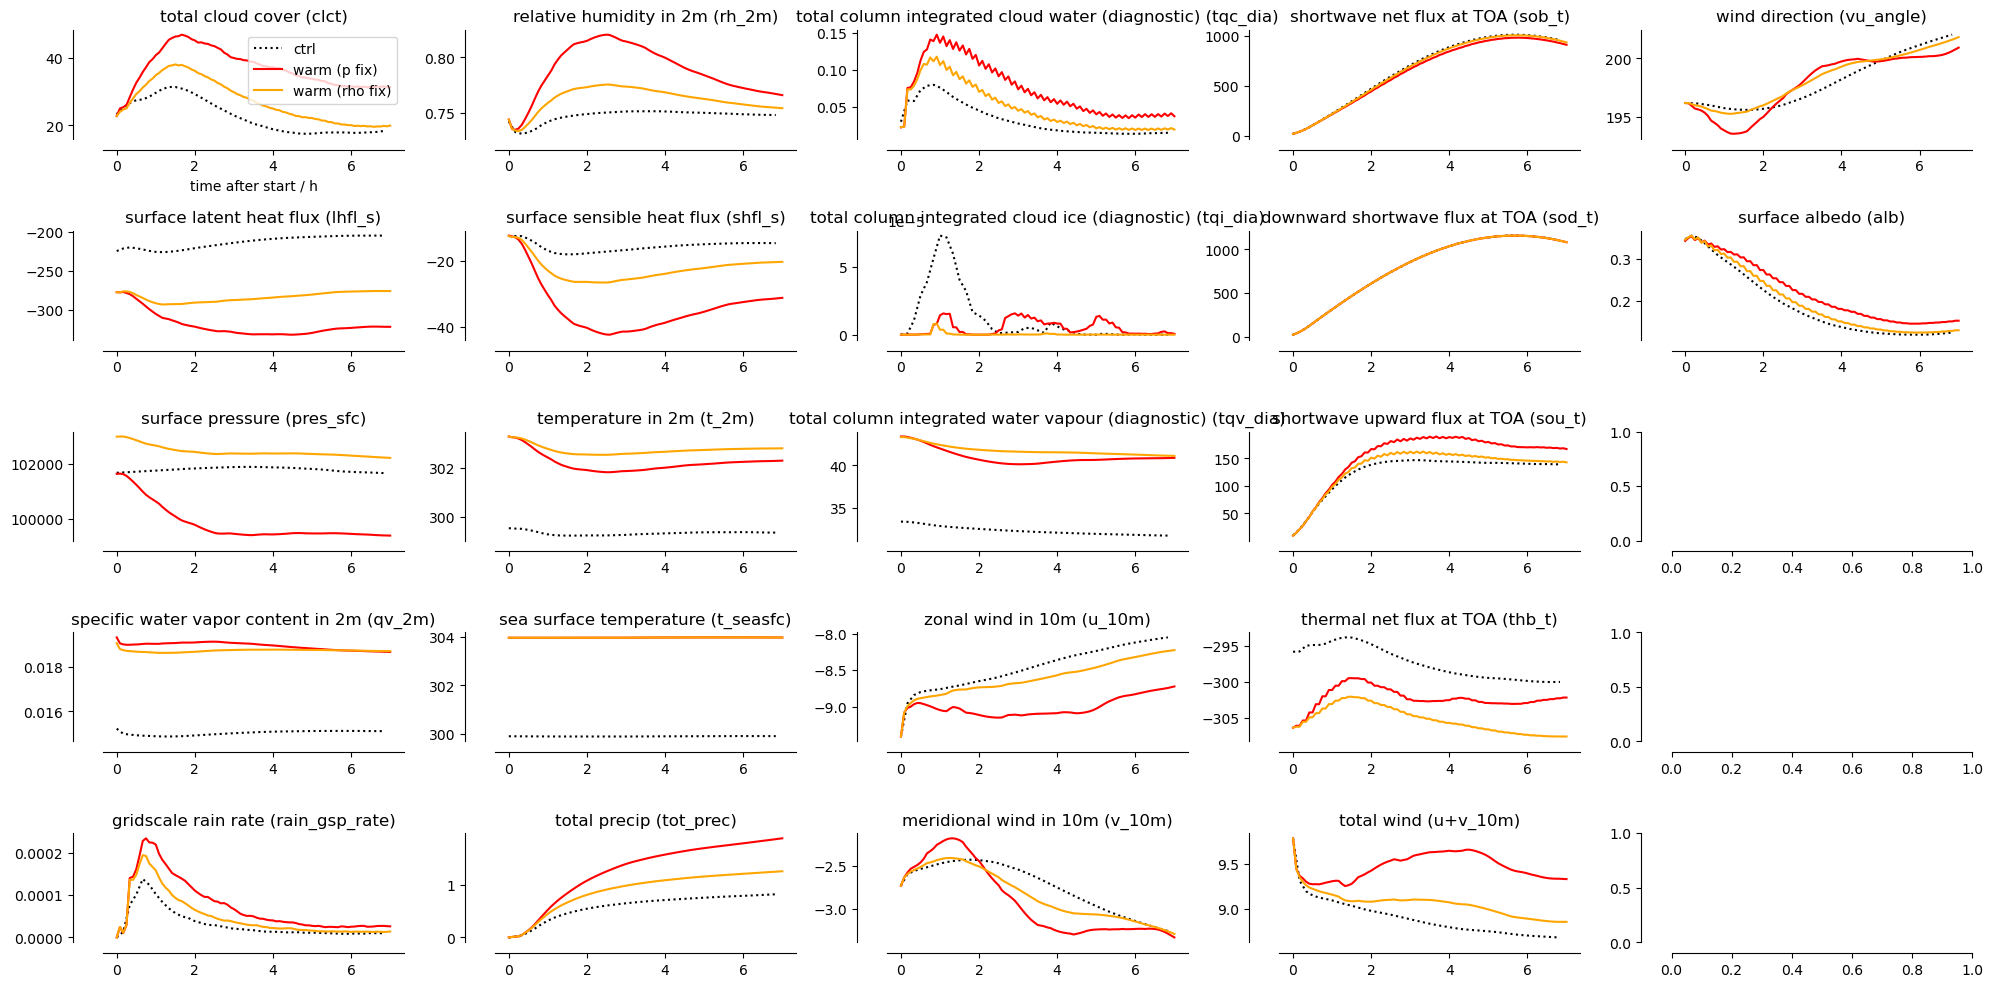

In [23]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import eurec4a
import xarray as xr    
import numpy as np
import pandas as pd
import calculations as cc
import postprocessing as pp
import importlib; importlib.reload(pp)
import matplotlib.pyplot as plt
import os
import file_handling as fh
from datetime import datetime

def save_composit_timeseries(path, savename, cut_borders=True):
    '''
    Loads surface and radiation data files from the given path, computes the mean for each, 
    merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - path (str): Path to the directory containing surface and radiation data files.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, drop_dims=False, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def save_matching_eurecadata(data_to_match, savename, cut_borders=True):
    '''
    Loads surface and radiation data from the EUREC4A dataset, aligns it with the given dataset, 
    computes the mean for each, merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - data_to_match (xarray.Dataset): Dataset used for aligning the EUREC4A data.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', skipna=True, keep_attrs=True)
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.radiation_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', skipna=True, keep_attrs=True).drop_vars('height_bnds').drop_dims(['height'])
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def fig_all_domain_means(data, labels, kwargs=False, verbose=False, integral=False, mean=False):
    '''
    Generates a grid of plots displaying mean data from multiple sources.

    Args:
    - data (list): List of xarray Datasets.
    - labels (list): Labels for the plotted data.
    - kwargs (list, optional): Additional arguments for plotting functions. Defaults to False.
    - verbose (bool, optional): Verbosity of plot generation. Defaults to False.
    - integral (bool, optional): Whether to compute and display the mean of each dataset. Defaults to False.
    - mean (bool, optional): If True, plots a horizontal line representing the mean value. Defaults to False.

    Returns:
    - plt.Figure: The generated figure.
    - np.ndarray: Axes objects of the figure.
    '''
    if not kwargs: kwargs = [dict() for d in data]
    m,n = cc.isqrt(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k)) 

    for i,var in enumerate(list(data[0])):
        ax = axs[positions[i]]
        for j, d in enumerate(data):
            if verbose: print(f'{i*(j+1) + j} {var}', end=', ')
            if mean:
                ax.axhline(0, label=None, color='black', lw=.5)
                integral = np.mean(d[var].values[d[var].values != -np.inf])
                ax.axhline(integral, label=f'mean({labels[j]}) = {integral:2f}', ls=':')
            t = d[var].time.values
            t = pd.to_datetime(t)
            t = t - d[var].time.values[0]
            t = t.total_seconds() / (60*60)
            y = d[var].values
            ax.plot(t, y, label=labels[j], **kwargs[j])
        ax.set_title(d[var].attrs['long_name'] + f' ({var})')
    axs[0,0].legend()
    if verbose: print('done')
    return fig, axs


def add_total_wind(data):
    data['u+v_10m'] = np.sqrt(data['u_10m']**2 + data['v_10m']**2)
    attributes = data['u_10m'].attrs.copy()
    attributes['standard_name'] = 'u+v_10m'
    attributes['long_name'] = 'total wind'
    del(attributes['param'])
    data['u+v_10m'] = data['u+v_10m'].assign_attrs(attributes)
    return data


def add_wind_direction(data):
    # Calculate wind direction in radians
    wind_direction_rad = np.arctan2(data['v_10m'], data['u_10m'])
    
    # Convert radians to degrees
    wind_direction_deg = np.degrees(wind_direction_rad)
    
    # Adjust negative values to get angles between 0 and 360 degrees
    wind_direction_deg = (wind_direction_deg + 360) % 360
    
    # Add wind direction to the dataset
    data['vu_angle'] = wind_direction_deg
    
    # Update attributes for the new variable
    attributes = data['u_10m'].attrs.copy()
    attributes['standard_name'] = 'vu_angle'
    attributes['long_name'] = 'wind direction'
    del(attributes['param'])
    data['vu_angle'] = data['vu_angle'].assign_attrs(attributes)
    
    return data

def add_albedo(data):
    # Calculate albedo
    albedo = data['sou_t'] / data['sod_t']
    
    # Add albedo to the dataset
    data['alb'] = albedo
    
    # Update attributes for the new variable
    attributes = data['sou_t'].attrs.copy()
    attributes['standard_name'] = 'alb'
    attributes['long_name'] = 'surface albedo'
    del(attributes['param'])
    data['alb'] = data['alb'].assign_attrs(attributes)
    
    return data


def add_diagnostics(data):
    data = add_total_wind(data)
    data = add_wind_direction(data)
    data = add_albedo(data)
    return data
    
def fig_all_domain_means_twowarmings(paths):
    '''
    Generates and displays a grid of plots showing mean data from different datasets 
    related to a warming simulation and a control dataset.

    Args:
    - paths [str,str]: Paths to the directories containing the data files.

    Returns:
    - plt.Figure: The generated figure.
    - np.ndarray: Axes objects of the figure.
    '''
    today = datetime.today().strftime('%Y%m%d')
    rhofix_timeseries  = f'data/{fh.basename(paths[0])}_{today}.nc'
    pfix_timeseries    = f'data/{fh.basename(paths[1])}_{today}.nc'
    control_timeseries = f'data/eurec4a_cntrl_{today}.nc'

    if not os.path.exists(rhofix_timeseries): 
        save_composit_timeseries(paths[0], rhofix_timeseries)
    if not os.path.exists(pfix_timeseries): 
        save_composit_timeseries(paths[1], pfix_timeseries)
    if not os.path.exists(control_timeseries):
        warm = xr.open_dataset(rhofix_timeseries)
        save_matching_eurecadata(warm, control_timeseries)

    ctrl = xr.open_dataset(control_timeseries)
    rfix = xr.open_dataset(rhofix_timeseries)
    pfix = xr.open_dataset(pfix_timeseries)
    ctrl = add_diagnostics(ctrl)
    rfix = add_diagnostics(rfix)
    pfix = add_diagnostics(pfix)
    data = {'ctrl':ctrl, 'warm (p fix)':pfix, 'warm (rho fix)':rfix}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [dict()] * (len(data)-2) + [{'ls' : ':'}] + [{'ls' : ':'}]
    kwargs = [{'ls' : ':', 'color':'black'}, {'color':'red'}, {'color':'orange'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=False)
    np.ravel(axs)[0].legend()
    np.ravel(axs)[0].set_xlabel('time after start / h')
    for ax in np.ravel(axs):
        # https://matplotlib.org/2.0.2/examples/pylab_examples/spine_placement_demo.html
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_position(('axes', -.1)) #
        ax.spines['left'  ].set_position(('axes', -.1)) # 
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    
    fig.tight_layout()
    return fig, axs

paths = ['/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05', 
         '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_06_pfix']
fig, ax = fig_all_domain_means_twowarmings(paths)
fig.savefig(f'img/fig_all_domain_means_twowarmings.png')
fig.show()

In [35]:
def initc_script_body(in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/test/',
                      warming_function='apply_warming_rho_fixed'):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
initc_files = [os.path.join('initc',f) for f in list_files(os.path.join(IN_DIRECTORY, 'initc'))]
create_directory_structure(initc_files, OUT_DIRECTORY)

for f in initc_files: print(f, flush=True)
print('', flush=True)

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = {warming_function}(d, varnames=varnames)
    d = add_prognostic_variables(d, varnames=varnames)
    d.to_netcdf(ofile)

initcon_varnames = dict()
initcon_varnames["pressure"] = "p"
initcon_varnames["temperature"] = "t"
varnames = get_varnames(initcon_varnames)
print(varnames, flush=True)
print('', flush=True)

ifile = os.path.join(IN_DIRECTORY,initc_files[0])
ofile = os.path.join(OUT_DIRECTORY,initc_files[0])
warm_atmospheric_profile(ifile, ofile, varnames)
print('done', flush=True)
'''

def launch_initc_script(in_directory='/work/mh1126/m300872/unchanged/',
                        out_directory='/work/mh1126/m300872/test/',
                        warming_function='apply_warming_rho_fixed'):
    script = fh.slurm_header(10) + fh.some_module_files() + \
             initc_script_body(in_directory, out_directory, warming_function)
    launch_script(script)

    
in_directory='/work/mh1126/m300872/unchanged/'
out_directory='/scratch/m/m300872/bc_test'
warming_function='apply_warming_p_fixed'

launch_initc_script(in_directory, out_directory, warming_function)

Submitted batch job 8138119


In [36]:
import subprocess as sup

def initc_script_body(in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/test/',
                      warming_function='apply_warming_rho_fixed'):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
initc_files = [os.path.join('initc',f) for f in list_files(os.path.join(IN_DIRECTORY, 'initc'))]
create_directory_structure(initc_files, OUT_DIRECTORY)

for f in initc_files: print(f, flush=True)
print('', flush=True)

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = {warming_function}(d, varnames=varnames)
    d = add_prognostic_variables(d, varnames=varnames)
    d.to_netcdf(ofile)

initcon_varnames = dict()
initcon_varnames["pressure"] = "p"
initcon_varnames["temperature"] = "t"
varnames = get_varnames(initcon_varnames)
print(varnames, flush=True)
print('', flush=True)

ifile = os.path.join(IN_DIRECTORY,initc_files[0])
ofile = os.path.join(OUT_DIRECTORY,initc_files[0])
warm_atmospheric_profile(ifile, ofile, varnames)
print('done', flush=True)
'''

def launch_initc_script(in_directory='/work/mh1126/m300872/unchanged/',
                        out_directory='/work/mh1126/m300872/test/',
                        warming_function='apply_warming_rho_fixed'):
    script = fh.slurm_header(10) + fh.some_module_files() + \
             initc_script_body(in_directory, out_directory, warming_function)
    launch_script(script)

def sstsic_script_body(division=False, 
                      in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/scratch/m/m300872/bc_test',
                      temperatures=(300,304)):
    return f'''
import netCDF4 as nc
import xarray as xr
import subprocess as sup

IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
temperatures = {temperatures}

print(division)
sstsic_files = list_files(os.path.join(IN_DIRECTORY, 'sst_sic'), ['sst_sic_DOM0'])
sstsic_files = [os.path.join('sst_sic',f) for f in sstsic_files if f.endswith('.nc')]
if division: sstsic_files = sublist(sstsic_files, division[0], division[1])
create_directory_structure(sstsic_files, OUT_DIRECTORY)
    
# pack arguments
delta = temperatures[1] - temperatures[0]
args_list = list()
for f in sstsic_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,delta))

for args in args_list:
    # copy original file, then overwrite SST timestepwise (file to big to write at once)
    (ifile, ofile, delta) = args
    sup.call(['cp', ifile, ofile])
    time_shape = xr.open_dataset(ifile).time.values.shape
    with nc.Dataset(args[1], mode='a') as fp:
        for i in range(time_shape[0]):
            chunk = xr.open_dataset(ifile)['SST'].isel(time=i).values + delta
            fp['SST'][i] = chunk
            
print('done', flush=True)
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    sup.call(['sbatch', name])
    try_remove(name)

def launch_sstsic_script(n_scripts=3, 
                         in_directory='/work/mh1126/m300872/unchanged/',
                         out_directory='/scratch/m/m300872/bc_test',
                         temperatures=(300,304)):
    for script_id in range(n_scripts):
        script = fh.slurm_header(15) + fh.some_module_files() + \
                 sstsic_script_body(division=(n_scripts, script_id), 
                                    in_directory=in_directory, out_directory=out_directory,
                                    temperatures=temperatures)
        launch_script(script)


in_directory='/work/mh1126/m300872/unchanged/'
out_directory='/scratch/m/m300872/bc_test'
warming_function='apply_warming_p_fixed'
sst_temperatures=(300,304)

launch_initc_script(in_directory, out_directory, warming_function)
launch_sstsic_script(in_directory, out_directory, sst_temperatures)

Submitted batch job 8138120
Submitted batch job 8138121
Submitted batch job 8138122


In [19]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import subprocess

def initc_script_body(in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/test/',
                      warming_function='apply_warming_rho_fixed'):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
initc_files = [os.path.join('initc',f) for f in list_files(os.path.join(IN_DIRECTORY, 'initc'))]
create_directory_structure(initc_files, OUT_DIRECTORY)

for f in initc_files: print(f, flush=True)
print('', flush=True)

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = {warming_function}(d, varnames=varnames)
    d = add_prognostic_variables(d, varnames=varnames)
    d.to_netcdf(ofile)

initcon_varnames = dict()
initcon_varnames["pressure"] = "p"
initcon_varnames["temperature"] = "t"
varnames = get_varnames(initcon_varnames)
print(varnames, flush=True)
print('', flush=True)

ifile = os.path.join(IN_DIRECTORY,initc_files[0])
ofile = os.path.join(OUT_DIRECTORY,initc_files[0])
warm_atmospheric_profile(ifile, ofile, varnames)
print('done', flush=True)
'''

def launch_initc_script(in_directory='/work/mh1126/m300872/unchanged/',
                        out_directory='/work/mh1126/m300872/test/',
                        warming_function='apply_warming_rho_fixed'):
    script = fh.slurm_header(10, log_path=out_directory) + fh.some_module_files() + \
             initc_script_body(in_directory, out_directory, warming_function)
    launch_script(script)

def sstsic_script_body(division=False, 
                      in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/scratch/m/m300872/bc_test',
                      temperatures=(300,304)):
    return f'''
import netCDF4 as nc
import xarray as xr
import subprocess

IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
temperatures = {temperatures}

print(division)
sstsic_files = list_files(os.path.join(IN_DIRECTORY, 'sst_sic'), ['sst_sic_DOM0'])
sstsic_files = [os.path.join('sst_sic',f) for f in sstsic_files if f.endswith('.nc')]
if division: sstsic_files = sublist(sstsic_files, division[0], division[1])
create_directory_structure(sstsic_files, OUT_DIRECTORY)
    
# pack arguments
delta = temperatures[1] - temperatures[0]
args_list = list()
for f in sstsic_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,delta))

for args in args_list:
    # copy original file, then overwrite SST timestepwise (file to big to write at once)
    (ifile, ofile, delta) = args
    subprocess.call(['cp', ifile, ofile])
    time_shape = xr.open_dataset(ifile).time.values.shape
    with nc.Dataset(args[1], mode='a') as fp:
        for i in range(time_shape[0]):
            chunk = xr.open_dataset(ifile)['SST'].isel(time=i).values + delta
            fp['SST'][i] = chunk
            
print('done', flush=True)
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    subprocess.call(['sbatch', name])
    try_remove(name)

def launch_sstsic_script(in_directory='/work/mh1126/m300872/unchanged/',
                         out_directory='/scratch/m/m300872/bc_test',
                         temperatures=(300,304),
                         n_scripts=3):
    for script_id in range(n_scripts):
        script = fh.slurm_header(15, log_path=out_directory) + fh.some_module_files() + \
                 sstsic_script_body(division=(n_scripts, script_id), 
                                    in_directory=in_directory, out_directory=out_directory,
                                    temperatures=temperatures)
        launch_script(script)

def latbc_script_body(warming_function, in_directory, out_directory, match_keywords, 
                      division=False, temperatures=(304,300)):
    return f'''
def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    print(d[varnames['temperature']].values, flush=True) #db
    d = {warming_function}(d, varnames=varnames)
    print(d[varnames['temperature']].values, flush=True) #db
    d.to_netcdf(ofile)
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
latbc_files = list_files(IN_DIRECTORY, {match_keywords})
if division: latbc_files = sublist(latbc_files, division[0], division[1])

# In case of a failed script, I want to know in details what script to relaunch
# therefore here comes some printout
print('latbc_script', flush=True)
print('IN_DIRECTORY: ', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY: ', OUT_DIRECTORY, flush=True)
print('division: ', division, flush=True)
for f in latbc_files: print(f, flush=True)
print('', flush=True)

# make sure directory structure is there
create_directory_structure(latbc_files, OUT_DIRECTORY)
# Compile arguments
varnames = get_varnames({{"pressure" : "pres", "temperature" : "temp"}})
args_list = list()
for f in latbc_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile, ofile, varnames))

# Do the work
for args in args_list:
    print(args, flush=True)
    warm_atmospheric_profile(*args)

print('done', flush=True)
'''


def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    subprocess.call(['sbatch', name])
    try_remove(name)

def launch_latbc_scripts(in_directory='/work/mh1126/m300872/unchanged/', 
                         out_directory='/work/mh1126/m300872/test/',
                         warming_function = 'apply_warming_rho_fixed',
                         keywords = ['latbc', 'PR1250m_DOM01', '.nc'],
                         n_scripts=100):
    for script_id in range(n_scripts):
        division=(n_scripts, script_id)
        script = create_latbc_script(in_directory, out_directory, warming_function, keywords, division)
        launch_script(script)
        
def create_latbc_script(in_directory='/work/mh1126/m300872/unchanged/', 
                        out_directory='/work/mh1126/m300872/test/', 
                        warming_function='apply_warming_rho_fixed', 
                        keywords=['latbc', 'PR1250m_DOM01', '.nc'], 
                        division=None, verbose=False):
    if verbose: 
        latbc_files = fh.list_files(in_directory, keywords)
        print(division)
        if not division == None: latbc_files = fh.sublist(latbc_files, division[0], division[1])
        for f in latbc_files: print('  ', f)
    script = fh.slurm_header(10, log_path=out_directory) + fh.some_module_files() + \
             latbc_script_body(warming_function, in_directory, out_directory, keywords, division=division)
    return script

def launch_all_scripts(in_directory='/work/mh1126/m300872/unchanged/',
                       out_directory='/scratch/m/m300872/bc_test',
                       warming_function='apply_warming_p_fixed'):
    launch_initc_script(in_directory, out_directory, warming_function)
    launch_sstsic_script(in_directory, out_directory, n_scripts=3)
    launch_latbc_scripts(in_directory, out_directory, warming_function, n_scripts=100)

def relaunch_failed_scripts(divisions,
                            in_directory='/work/mh1126/m300872/unchanged/',
                            out_directory='/scratch/m/m300872/bc_test',
                            warming_function='apply_warming_p_fixed'):
    # relaunch of failed scripts (i receive emails for failed scripts):
    for division in divisions:
        script = create_latbc_script(in_directory, out_directory, warming_function, latbc_keywords, division, verbose=True)
        launch_script(script)
        
launch_all_scripts(out_directory='/scratch/m/m300872/bc_test4')

Submitted batch job 8140974
Submitted batch job 8140975
Submitted batch job 8140976
Submitted batch job 8140977
Submitted batch job 8140978
Submitted batch job 8140979
Submitted batch job 8140980
Submitted batch job 8140981
Submitted batch job 8140982
Submitted batch job 8140983
Submitted batch job 8140984
Submitted batch job 8140985
Submitted batch job 8140986
Submitted batch job 8140987
Submitted batch job 8140988
Submitted batch job 8140989
Submitted batch job 8140990
Submitted batch job 8140991
Submitted batch job 8140992
Submitted batch job 8140993
Submitted batch job 8140994
Submitted batch job 8140995
Submitted batch job 8140996
Submitted batch job 8140997
Submitted batch job 8140998
Submitted batch job 8140999
Submitted batch job 8141000
Submitted batch job 8141001
Submitted batch job 8141002
Submitted batch job 8141003
Submitted batch job 8141004
Submitted batch job 8141005
Submitted batch job 8141006
Submitted batch job 8141007
Submitted batch job 8141008
Submitted batch job 

In [17]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import importlib
importlib.reload(fh)

fh.check_queue()

"             JOBID PARTITION                      NAME     USER ST       TIME  NODES     NODELIST(REASON)           START_TIME"
"           8140178   compute                 les_test2  m300872 PD       0:00    120           (Priority)  2023-12-20T02:12:55"
"           8140181   compute                 les_test2  m300872 PD       0:00    120           (Priority)  2023-12-20T02:12:55"
"           8140103 interacti        spawner-jupyterhub  m300872  R      57:26      1               l40050  2023-12-19T23:04:18"


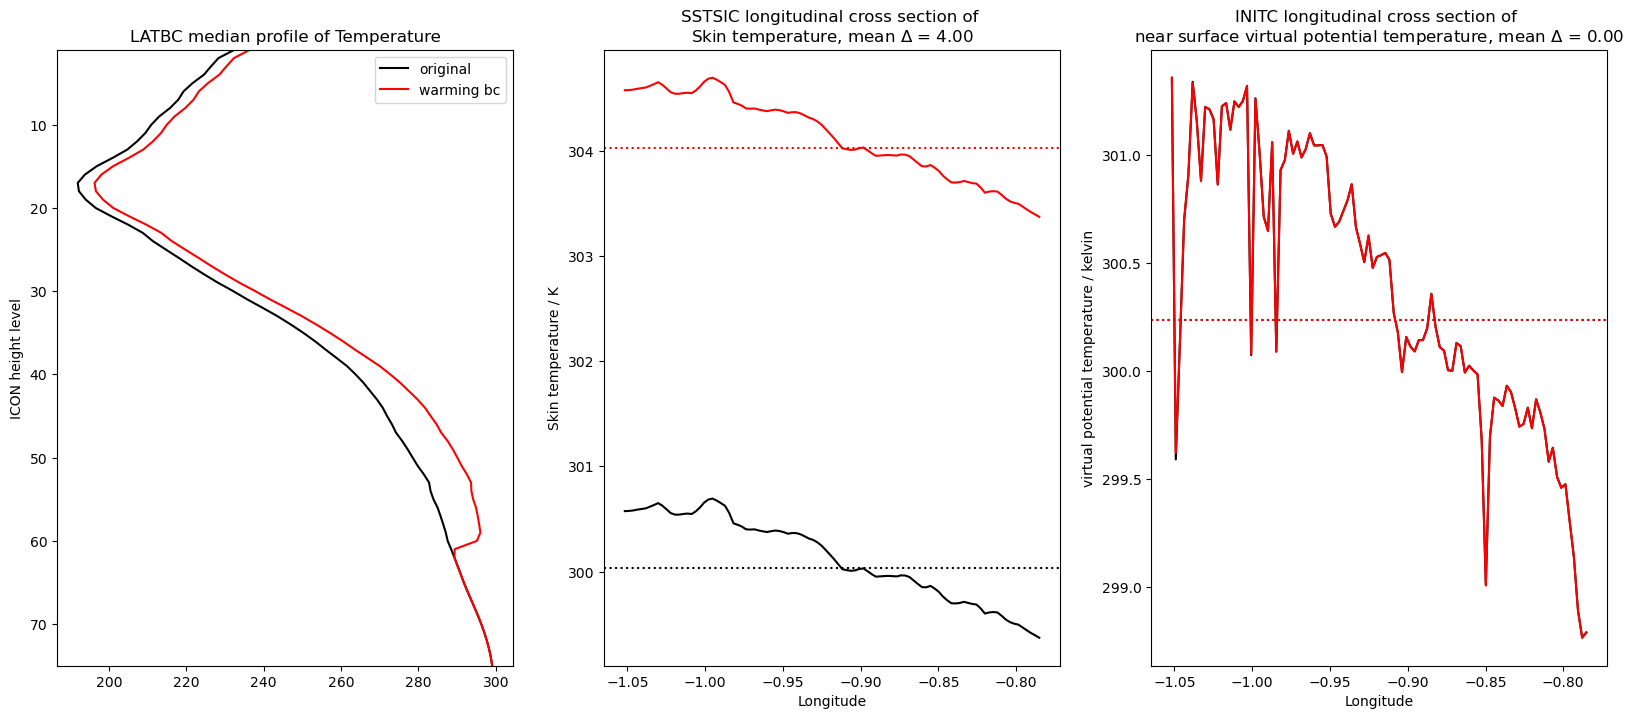

In [15]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import file_handling as fh

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc

import matplotlib.pyplot as plt

def open_initc_data(bc_dir, 
                    initc_rel_path='initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
                    grid_path=None):
    data = xr.open_dataset(os.path.join(bc_dir, initc_rel_path))
    data = pp.clean_volume_data(data, convert_time=False)
    data = data.isel(time=0) 
    data = pp.add_grid(data, grid_path)
    data = data.isel(height=len(data.height.values)-1)
    return data

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def ax_initc_cross_section_comparison(ax, bc_dirs, varname):
    initc_rel_path='initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
    grid_path = os.path.join(bc_dirs[0], 'grids/EUREC4A_PR1250m_DOM01.nc')

    data = [open_initc_data(dir_path, grid_path=grid_path) for dir_path in bc_dirs]
    kwargs = [{'color':'black', 'label':fh.basename(bc_dirs[0])}, {'color':'red', 'label':fh.basename(bc_dirs[1])}]

    for d, kw in zip(data, kwargs):
        ax = ax_longitudinal_section(ax, d, varname, kw)
        ax.axhline(d[varname].mean(dim='cell'), ls=':', **kw)
    mean_diff = np.abs(data[0][varname].mean(dim="cell").values - data[1][varname].mean(dim="cell").values)
    ax.set_title(f'INITC longitudinal cross section of \nnear surface {d[varname].attrs["long_name"]}, mean $\Delta$ = {mean_diff:.2f}')
    return ax

def open_sstsic_data(bc_dir, initc_rel_path='sst_sic/data/sst_sic_DOM01.nc'):
    data = xr.open_dataset(os.path.join(bc_dir, initc_rel_path))
    # data = pp.clean_surface_data(data, convert_time=False)
    data = data.isel(time=0) 
    data = data.rename({'clon':'lon', 'clat':'lat'})
    # data = pp.add_grid(data, grid_path)
    # data = data.isel(height=len(data.height.values)-1)
    return data


def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def ax_sst_cross_section_comparison(ax, bc_dirs, varname):
    initc_rel_path='initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
    grid_path = os.path.join(bc_dirs[0], 'grids/EUREC4A_PR1250m_DOM01.nc')

    data = [open_sstsic_data(dir_path) for dir_path in bc_dirs]
    kwargs = [{'color':'black', 'label':fh.basename(bc_dirs[0])}, {'color':'red', 'label':fh.basename(bc_dirs[1])}]

   
    for d, kw in zip(data, kwargs):
        ax = ax_longitudinal_section(ax, d, varname, kw)
        ax.axhline(d[varname].mean(dim='cell'), ls=':', **kw)
    mean_diff = np.abs(data[0][varname].mean(dim="cell").values - data[1][varname].mean(dim="cell").values)
    ax.set_title(f'SSTSIC longitudinal cross section of \n{d[varname].attrs["long_name"]}, mean $\Delta$ = {mean_diff:.2f}')
    return ax

def open_latbc_data_profile(bc_dir, latbc_rel_path='latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010812.nc'):
    data = xr.open_dataset(os.path.join(bc_dir, latbc_rel_path))
    data = data.isel(time=0).median(dim='ncells', keep_attrs=True)
    data = cc.add_relative_humidity(data)
    return data

def ax_compare_boundary_condition_profiles(ax, bc_dirs, varname='temp'):
    data = [open_latbc_data_profile(bc) for bc in bc_dirs]
    kwargs = [{'label':'original', 'color':'black'}, {'label':'warming bc', 'color':'red'}]
    
    for d, kwarg in zip(data, kwargs):
        ax.plot(d[varname].values, d[d[varname].dims[0]].values, **kwarg)
    ax.set_ylim(d[d.qv.dims[0]].values[-1], d[d.qv.dims[0]].values[0])
    ax.legend()
    try:    ax.set_xlabel(f'{warming[varname].attrs["long_name"]} / {warming[varname].attrs["units"]}')
    except: pass
    ax.set_ylabel('ICON height level')
    ax.set_title(f'LATBC median profile of {d[varname].attrs["long_name"]}')
    return ax


def fixedfig_latbc_initc_sst_quick_comparison():
    bc_ctrl = '/work/mh1126/m300872/unchanged/'
    bc_warm = '/work/mh1126/m300872/moist_adiabatic_rhofix/'
    bc_warm = '/scratch/m/m300872/bc_test2'
    fig, axs = plt.subplots(1,3, figsize=(20,8))
    ax_compare_boundary_condition_profiles(axs[0], [bc_ctrl, bc_warm])
    ax_sst_cross_section_comparison(axs[1], [bc_ctrl, bc_warm], 'SST')
    ax_initc_cross_section_comparison(axs[2], [bc_ctrl, bc_warm], 'theta_v')
    return fig, axs

fig, ax = fixedfig_latbc_initc_sst_quick_comparison()
fig.savefig('img/fixedfig_latbc_initc_sst_quick_comparison.png')
fig.show()

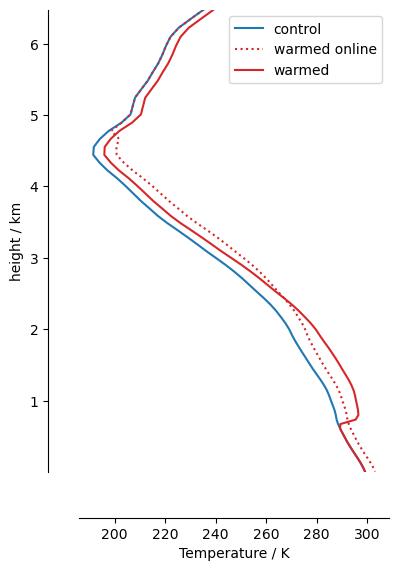

In [16]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import xarray as xr
import file_handling as fh
import metpy.calc
import metpy.units
import postprocessing as pp
# import eurec4a
import calculations as cc

import importlib
importlib.reload(cc)

import matplotlib.pyplot as plt
import plot_utils as pu

def ax_vertical_profile(ax, dataset, var, kwargs={}):
    ax.plot(dataset[var], dataset[dataset[var].dims[0]].values / 1000, **kwargs)
    ax.set_ylim(dataset[dataset[var].dims[0]].values[-1] / 1000, dataset[dataset[var].dims[0]].values[0] / 1000)
    ax.set_ylabel('height / km')
    try: ax.set_xlabel(dataset[var].attrs['long_name'] + ' / ' + dataset[var].attrs['units'] )
    except: pass
    ax = pu.offset_axis(ax)
    return ax

def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    dataset = xr.open_mfdataset(files[0])
    dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    dataset = dataset.isel(time=0)
    dataset = cc.add_relative_humidity(dataset)
    dataset = cc.add_prognostic_variables(dataset)
    dataset = cc.replace_level_with_height(dataset, 'height_3')
    return dataset

def fig_boundarycon_comparison(var='temp'):
    fig, ax = plt.subplots(figsize=(4,6))
    path = '/work/mh1126/m300872/unchanged/'
    dataset = open_boundary_conditions(os.path.join(path, 'latbc'))
    ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:blue', 'label':'control'})
    
    varnames = cc.get_varnames() #{'pressure':'p', 'temperature':'t'})
    dataset = cc.apply_warming_p_fixed(dataset, varnames=varnames)
    ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:red', 'label':'warmed online', 'ls':':'})
    
    path = '/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/'
    path = '/scratch/m/m300872/bc_test2/'
    dataset = open_boundary_conditions(os.path.join(path, 'latbc'))
    ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:red', 'label':'warmed'})
    ax.legend()
    return fig, ax

fig, ax = fig_boundarycon_comparison()
fig.show()

In [25]:
os.listdir('/scratch/m/m300872/bc_test')

['initc', 'latbc', 'sst_sic']

In [28]:
sorted(os.listdir('/scratch/m/m300872/bc_test/latbc/20200108'))

['latbc_EUREC4A_PR1250m_DOM01_2020010801.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010802.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010803.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010804.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010805.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010806.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010807.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010808.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010809.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010810.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010811.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010812.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010813.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010814.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010815.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010816.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010817.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010818.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010819.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010820.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020010821.nc',
 'latbc_EUREC4A_PR1250m_DOM01_2020

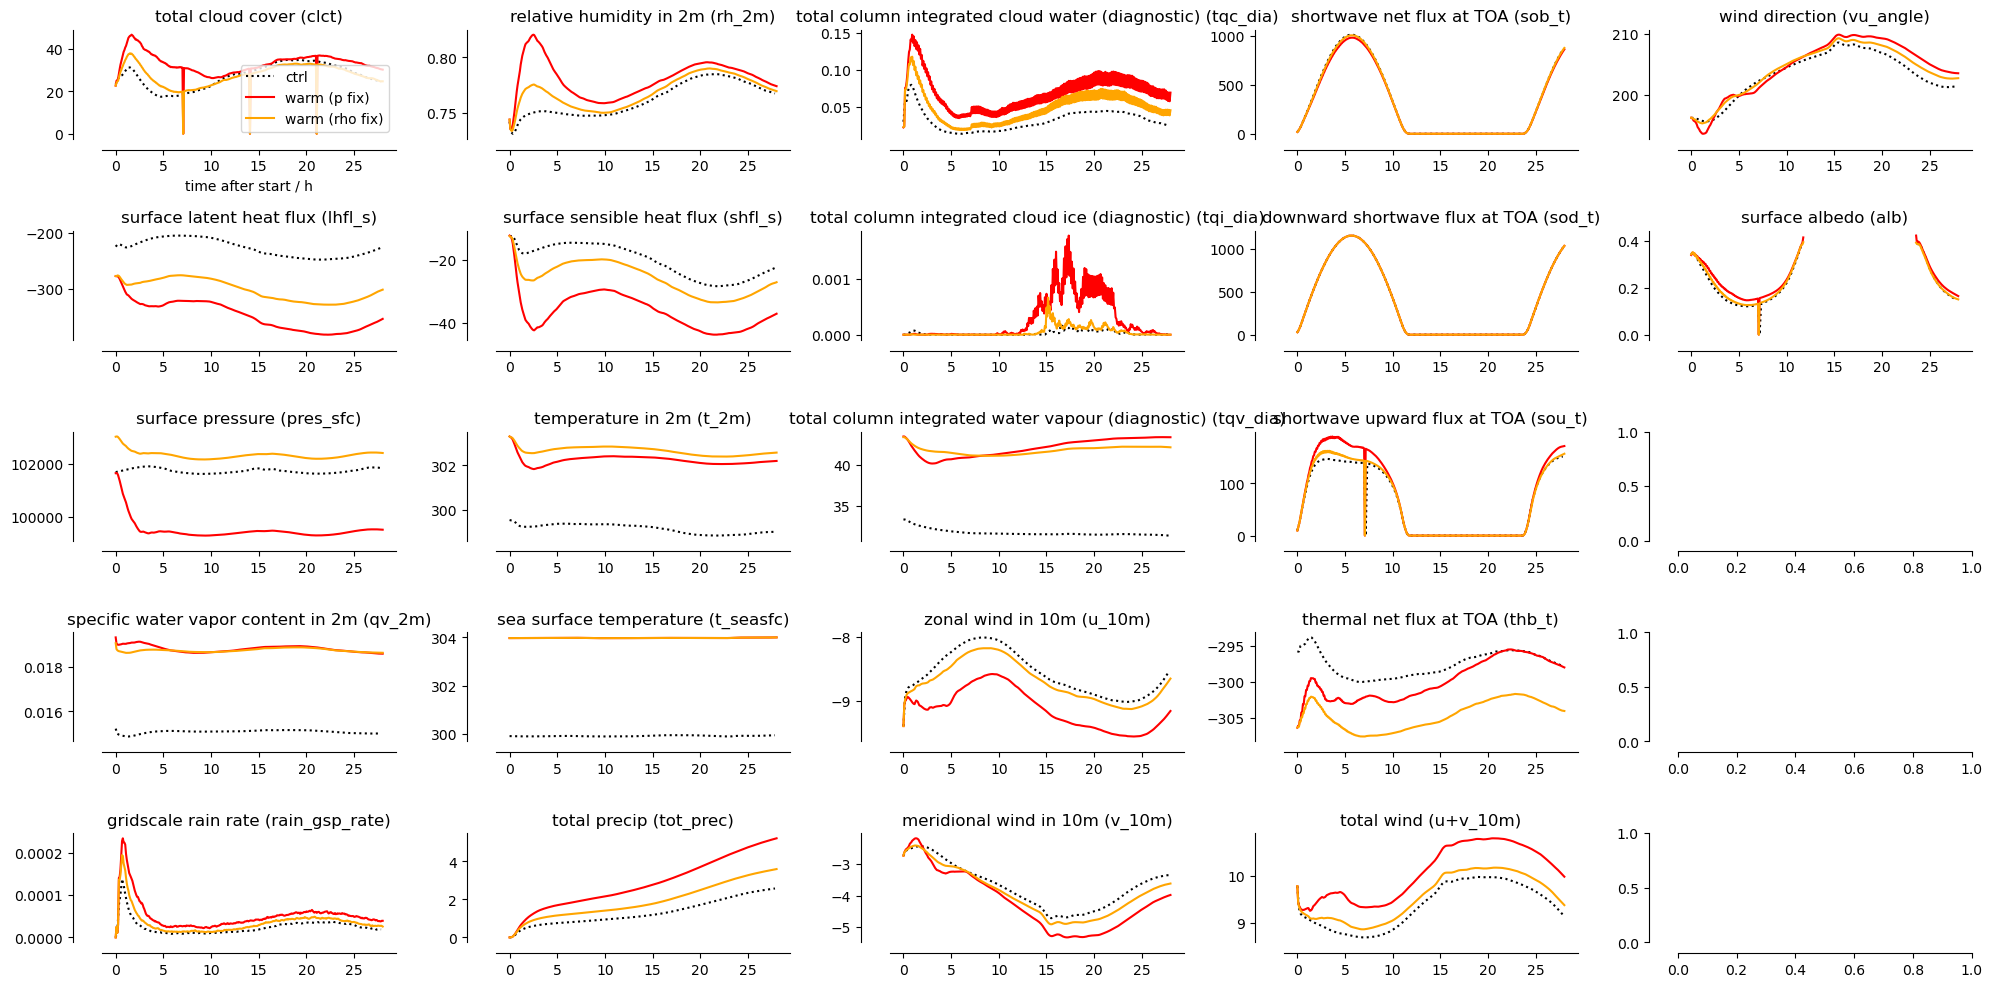

In [2]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import eurec4a
import xarray as xr    
import numpy as np
import pandas as pd
import calculations as cc
import postprocessing as pp
import importlib; importlib.reload(pp)
import matplotlib.pyplot as plt
import os
import file_handling as fh
from datetime import datetime

def save_composit_timeseries(path, savename, cut_borders=True):
    '''
    Loads surface and radiation data files from the given path, computes the mean for each, 
    merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - path (str): Path to the directory containing surface and radiation data files.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, drop_dims=False, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def save_matching_eurecadata(data_to_match, savename, cut_borders=True):
    '''
    Loads surface and radiation data from the EUREC4A dataset, aligns it with the given dataset, 
    computes the mean for each, merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - data_to_match (xarray.Dataset): Dataset used for aligning the EUREC4A data.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', skipna=True, keep_attrs=True)
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.radiation_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', skipna=True, keep_attrs=True).drop_vars('height_bnds').drop_dims(['height'])
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def fig_all_domain_means(data, labels, kwargs=False, verbose=False, integral=False, mean=False):
    '''
    Generates a grid of plots displaying mean data from multiple sources.

    Args:
    - data (list): List of xarray Datasets.
    - labels (list): Labels for the plotted data.
    - kwargs (list, optional): Additional arguments for plotting functions. Defaults to False.
    - verbose (bool, optional): Verbosity of plot generation. Defaults to False.
    - integral (bool, optional): Whether to compute and display the mean of each dataset. Defaults to False.
    - mean (bool, optional): If True, plots a horizontal line representing the mean value. Defaults to False.

    Returns:
    - plt.Figure: The generated figure.
    - np.ndarray: Axes objects of the figure.
    '''
    if not kwargs: kwargs = [dict() for d in data]
    m,n = cc.isqrt(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k)) 

    for i,var in enumerate(list(data[0])):
        ax = axs[positions[i]]
        for j, d in enumerate(data):
            if verbose: print(f'{i*(j+1) + j} {var}', end=', ')
            if mean:
                ax.axhline(0, label=None, color='black', lw=.5)
                integral = np.mean(d[var].values[d[var].values != -np.inf])
                ax.axhline(integral, label=f'mean({labels[j]}) = {integral:2f}', ls=':')
            t = d[var].time.values
            t = pd.to_datetime(t)
            t = t - d[var].time.values[0]
            t = t.total_seconds() / (60*60)
            y = d[var].values
            ax.plot(t, y, label=labels[j], **kwargs[j])
        ax.set_title(d[var].attrs['long_name'] + f' ({var})')
    axs[0,0].legend()
    if verbose: print('done')
    return fig, axs


def add_total_wind(data):
    data['u+v_10m'] = np.sqrt(data['u_10m']**2 + data['v_10m']**2)
    attributes = data['u_10m'].attrs.copy()
    attributes['standard_name'] = 'u+v_10m'
    attributes['long_name'] = 'total wind'
    del(attributes['param'])
    data['u+v_10m'] = data['u+v_10m'].assign_attrs(attributes)
    return data


def add_wind_direction(data):
    # Calculate wind direction in radians
    wind_direction_rad = np.arctan2(data['v_10m'], data['u_10m'])
    
    # Convert radians to degrees
    wind_direction_deg = np.degrees(wind_direction_rad)
    
    # Adjust negative values to get angles between 0 and 360 degrees
    wind_direction_deg = (wind_direction_deg + 360) % 360
    
    # Add wind direction to the dataset
    data['vu_angle'] = wind_direction_deg
    
    # Update attributes for the new variable
    attributes = data['u_10m'].attrs.copy()
    attributes['standard_name'] = 'vu_angle'
    attributes['long_name'] = 'wind direction'
    del(attributes['param'])
    data['vu_angle'] = data['vu_angle'].assign_attrs(attributes)
    
    return data

def add_albedo(data):
    # Calculate albedo
    albedo = data['sou_t'] / data['sod_t']
    
    # Add albedo to the dataset
    data['alb'] = albedo
    
    # Update attributes for the new variable
    attributes = data['sou_t'].attrs.copy()
    attributes['standard_name'] = 'alb'
    attributes['long_name'] = 'surface albedo'
    del(attributes['param'])
    data['alb'] = data['alb'].assign_attrs(attributes)
    
    return data


def add_diagnostics(data):
    data = add_total_wind(data)
    data = add_wind_direction(data)
    data = add_albedo(data)
    return data
    
def fig_all_domain_means_twowarmings(paths):
    '''
    Generates and displays a grid of plots showing mean data from different datasets 
    related to a warming simulation and a control dataset.

    Args:
    - paths [str,str]: Paths to the directories containing the data files.

    Returns:
    - plt.Figure: The generated figure.
    - np.ndarray: Axes objects of the figure.
    '''
    today = datetime.today().strftime('%Y%m%d')
    rhofix_timeseries  = f'data/{fh.basename(paths[0])}_{today}.nc'
    pfix_timeseries    = f'data/{fh.basename(paths[1])}_{today}.nc'
    control_timeseries = f'data/eurec4a_cntrl_{today}.nc'

    if not os.path.exists(rhofix_timeseries): 
        save_composit_timeseries(paths[0], rhofix_timeseries)
    if not os.path.exists(pfix_timeseries): 
        save_composit_timeseries(paths[1], pfix_timeseries)
    if not os.path.exists(control_timeseries):
        warm = xr.open_dataset(rhofix_timeseries)
        save_matching_eurecadata(warm, control_timeseries)

    ctrl = xr.open_dataset(control_timeseries)
    rfix = xr.open_dataset(rhofix_timeseries)
    pfix = xr.open_dataset(pfix_timeseries)
    ctrl = add_diagnostics(ctrl)
    rfix = add_diagnostics(rfix)
    pfix = add_diagnostics(pfix)
    data = {'ctrl':ctrl, 'warm (p fix)':pfix, 'warm (rho fix)':rfix}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [dict()] * (len(data)-2) + [{'ls' : ':'}] + [{'ls' : ':'}]
    kwargs = [{'ls' : ':', 'color':'black'}, {'color':'red'}, {'color':'orange'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=False)
    np.ravel(axs)[0].legend()
    np.ravel(axs)[0].set_xlabel('time after start / h')
    for ax in np.ravel(axs):
        # https://matplotlib.org/2.0.2/examples/pylab_examples/spine_placement_demo.html
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_position(('axes', -.1)) #
        ax.spines['left'  ].set_position(('axes', -.1)) # 
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    
    fig.tight_layout()
    return fig, axs

paths = ['/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05', 
         '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_06_pfix']
fig, ax = fig_all_domain_means_twowarmings(paths)
fig.savefig(f'img/fig_all_domain_means_twowarmings.png')
fig.show()

In [1]:
import xarray as xr

path = 'data/moist_adiabatic_05_20231221.nc'
data = xr.open_dataset(path)
data.t_2m.values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

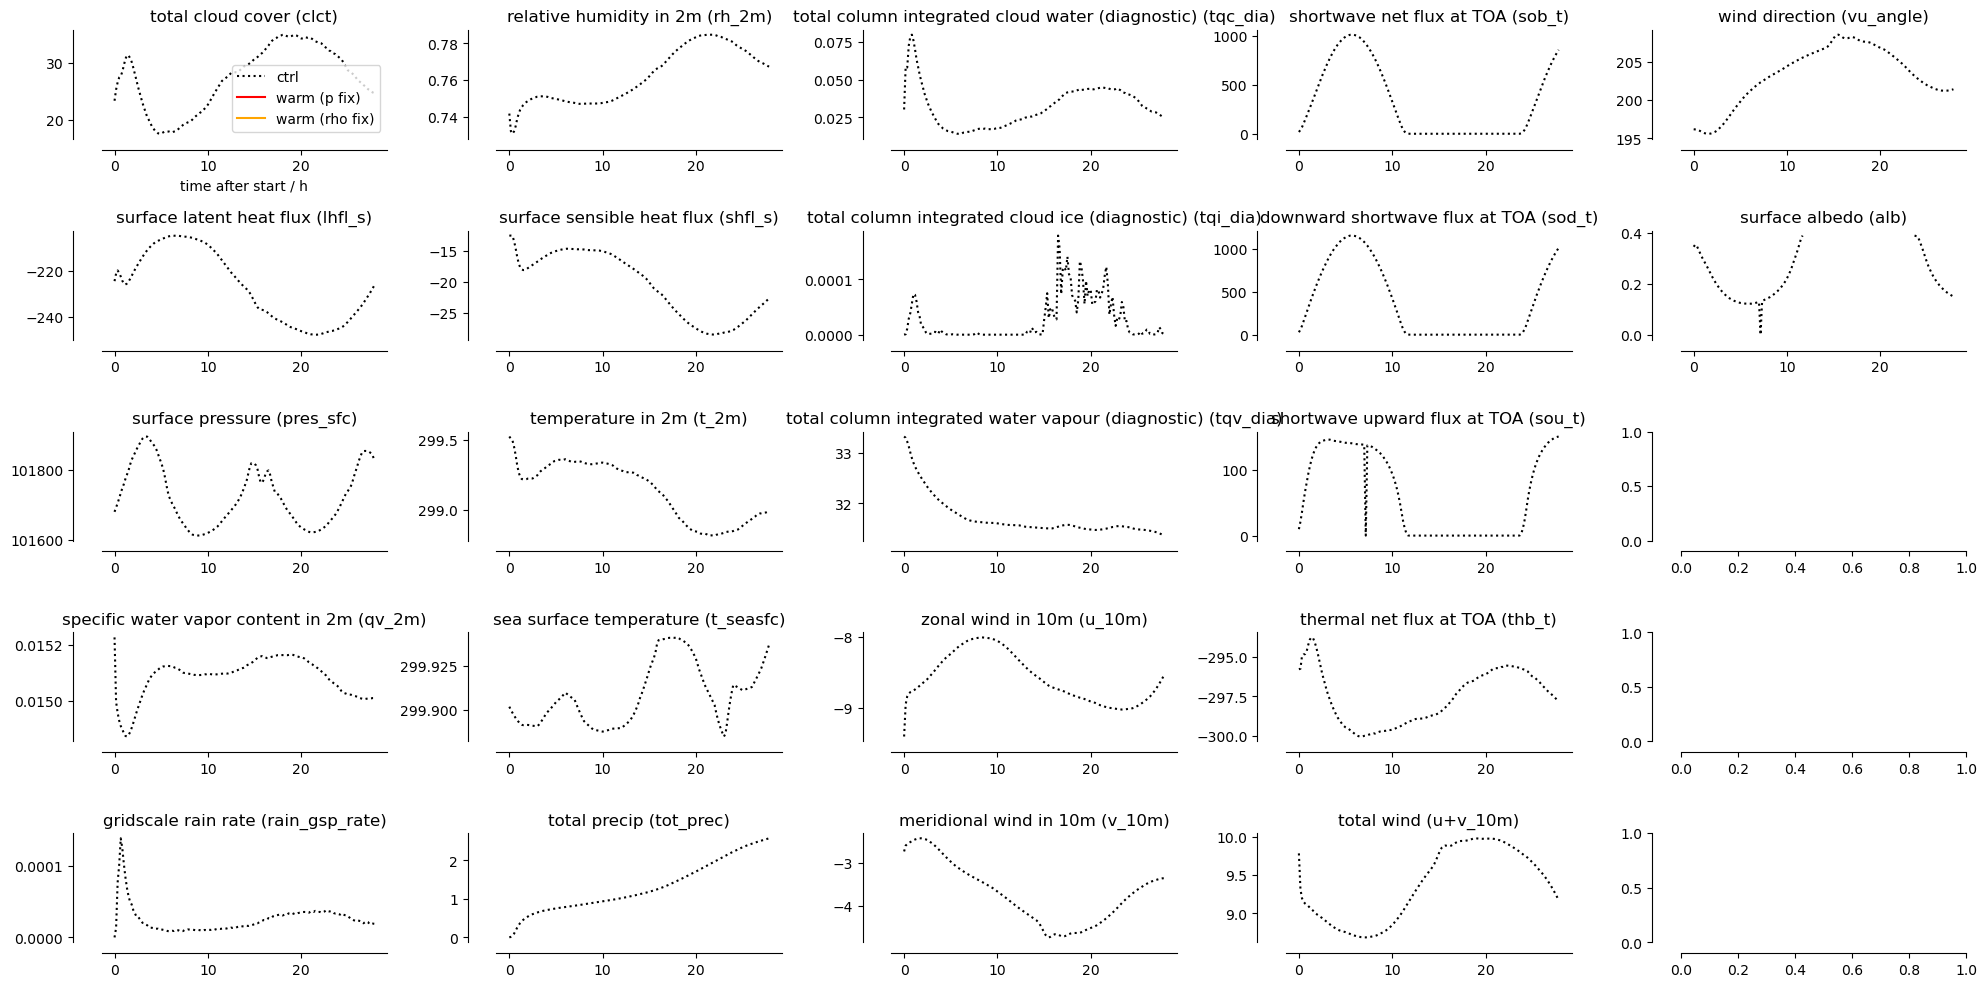

In [5]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import eurec4a
import xarray as xr    
import numpy as np
import pandas as pd
import calculations as cc
import postprocessing as pp
import importlib; importlib.reload(pp)
import matplotlib.pyplot as plt
import os
import file_handling as fh
from datetime import datetime

def save_composit_timeseries(path, savename, cut_borders=True):
    '''
    Loads surface and radiation data files from the given path, computes the mean for each, 
    merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - path (str): Path to the directory containing surface and radiation data files.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, drop_dims=False, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def save_matching_eurecadata(data_to_match, savename, cut_borders=True):
    '''
    Loads surface and radiation data from the EUREC4A dataset, aligns it with the given dataset, 
    computes the mean for each, merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - data_to_match (xarray.Dataset): Dataset used for aligning the EUREC4A data.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', skipna=True, keep_attrs=True)
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.radiation_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', skipna=True, keep_attrs=True).drop_vars('height_bnds').drop_dims(['height'])
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def fig_all_domain_means(data, labels, kwargs=False, verbose=False, integral=False, mean=False):
    '''
    Generates a grid of plots displaying mean data from multiple sources.

    Args:
    - data (list): List of xarray Datasets.
    - labels (list): Labels for the plotted data.
    - kwargs (list, optional): Additional arguments for plotting functions. Defaults to False.
    - verbose (bool, optional): Verbosity of plot generation. Defaults to False.
    - integral (bool, optional): Whether to compute and display the mean of each dataset. Defaults to False.
    - mean (bool, optional): If True, plots a horizontal line representing the mean value. Defaults to False.

    Returns:
    - plt.Figure: The generated figure.
    - np.ndarray: Axes objects of the figure.
    '''
    if not kwargs: kwargs = [dict() for d in data]
    m,n = cc.isqrt(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k)) 

    for i,var in enumerate(list(data[0])):
        ax = axs[positions[i]]
        for j, d in enumerate(data):
            if verbose: print(f'{i*(j+1) + j} {var}', end=', ')
            if mean:
                ax.axhline(0, label=None, color='black', lw=.5)
                integral = np.mean(d[var].values[d[var].values != -np.inf])
                ax.axhline(integral, label=f'mean({labels[j]}) = {integral:2f}', ls=':')
            t = d[var].time.values
            t = pd.to_datetime(t)
            t = t - d[var].time.values[0]
            t = t.total_seconds() / (60*60)
            y = d[var].values
            ax.plot(t, y, label=labels[j], **kwargs[j])
        ax.set_title(d[var].attrs['long_name'] + f' ({var})')
    axs[0,0].legend()
    if verbose: print('done')
    return fig, axs


def add_total_wind(data):
    """
    Calculate and add the total wind speed to the dataset.

    Args:
    data (xarray.Dataset): Input dataset containing 'u_10m' and 'v_10m' variables.

    Returns:
    xarray.Dataset: Modified dataset with 'u+v_10m' variable representing the total wind speed.

    Raises:
    KeyError: If 'u_10m' or 'v_10m' variables are not present in the dataset.
    """
    data['u+v_10m'] = np.sqrt(data['u_10m']**2 + data['v_10m']**2)
    attributes = data['u_10m'].attrs.copy()
    attributes['standard_name'] = 'u+v_10m'
    attributes['long_name'] = 'total wind'
    del(attributes['param'])
    data['u+v_10m'] = data['u+v_10m'].assign_attrs(attributes)
    return data


def add_wind_direction(data):
    """
    Calculate and add the wind direction to the dataset in degrees.

    Args:
    data (xarray.Dataset): Input dataset containing 'u_10m' and 'v_10m' variables.

    Returns:
    xarray.Dataset: Modified dataset with 'vu_angle' variable representing the wind direction in degrees.

    Raises:
    KeyError: If 'u_10m' or 'v_10m' variables are not present in the dataset.
    """
    wind_direction_rad = np.arctan2(data['v_10m'], data['u_10m'])
    wind_direction_deg = np.degrees(wind_direction_rad)
    wind_direction_deg = (wind_direction_deg + 360) % 360
    data['vu_angle'] = wind_direction_deg
    attributes = data['u_10m'].attrs.copy()
    attributes['standard_name'] = 'vu_angle'
    attributes['long_name'] = 'wind direction'
    del(attributes['param'])
    data['vu_angle'] = data['vu_angle'].assign_attrs(attributes)
    return data


def add_albedo(data):
    """
    Calculate and add surface albedo to the dataset.

    Args:
    data (xarray.Dataset): Input dataset containing 'sou_t' and 'sod_t' variables.

    Returns:
    xarray.Dataset: Modified dataset with 'alb' variable representing surface albedo.

    Raises:
    KeyError: If 'sou_t' or 'sod_t' variables are not present in the dataset.
    ZeroDivisionError: If 'sod_t' values contain zeros, leading to division by zero.
    """
    albedo = data['sou_t'] / data['sod_t']
    data['alb'] = albedo
    attributes = data['sou_t'].attrs.copy()
    attributes['standard_name'] = 'alb'
    attributes['long_name'] = 'surface albedo'
    del(attributes['param'])
    data['alb'] = data['alb'].assign_attrs(attributes)
    return data


def add_diagnostics(data):
    """
    Calculate and add multiple meteorological diagnostics to the dataset.

    Args:
    data (xarray.Dataset): Input dataset.

    Returns:
    xarray.Dataset: Dataset with added variables for total wind speed, wind direction, and surface albedo.

    Notes:
    This function internally calls 'add_total_wind', 'add_wind_direction', and 'add_albedo' functions.
    """
    data = add_total_wind(data)
    data = add_wind_direction(data)
    data = add_albedo(data)
    return data

    
def fig_all_domain_means_twowarmings(paths):
    '''
    Generates and displays a grid of plots showing mean data from different datasets 
    related to a warming simulation and a control dataset.

    Args:
    - paths [str,str]: Paths to the directories containing the data files.

    Returns:
    - plt.Figure: The generated figure.
    - np.ndarray: Axes objects of the figure.
    '''
    today = datetime.today().strftime('%Y%m%d')
    rhofix_timeseries  = f'data/{fh.basename(paths[0])}_{today}.nc'
    pfix_timeseries    = f'data/{fh.basename(paths[1])}_{today}.nc'
    control_timeseries = f'data/eurec4a_cntrl_{today}.nc'

    if not os.path.exists(rhofix_timeseries): 
        save_composit_timeseries(paths[0], rhofix_timeseries)
    if not os.path.exists(pfix_timeseries): 
        save_composit_timeseries(paths[1], pfix_timeseries)
    if not os.path.exists(control_timeseries):
        warm = xr.open_dataset(rhofix_timeseries)
        save_matching_eurecadata(warm, control_timeseries)

    ctrl = xr.open_dataset(control_timeseries)
    rfix = xr.open_dataset(rhofix_timeseries)
    pfix = xr.open_dataset(pfix_timeseries)
    ctrl = add_diagnostics(ctrl)
    rfix = add_diagnostics(rfix)
    pfix = add_diagnostics(pfix)
    data = {'ctrl':ctrl, 'warm (p fix)':pfix, 'warm (rho fix)':rfix}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [dict()] * (len(data)-2) + [{'ls' : ':'}] + [{'ls' : ':'}]
    kwargs = [{'ls' : ':', 'color':'black'}, {'color':'red'}, {'color':'orange'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=False)
    np.ravel(axs)[0].legend()
    np.ravel(axs)[0].set_xlabel('time after start / h')
    for ax in np.ravel(axs):
        # https://matplotlib.org/2.0.2/examples/pylab_examples/spine_placement_demo.html
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_position(('axes', -.1)) #
        ax.spines['left'  ].set_position(('axes', -.1)) # 
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    
    fig.tight_layout()
    return fig, axs

paths = ['/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05', 
         '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_06_pfix']
fig, ax = fig_all_domain_means_twowarmings(paths)
# fig.savefig(f'img/fig_all_domain_means_twowarmings.png')
fig.show()

In [ ]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import eurec4a
import xarray as xr    
import numpy as np
import pandas as pd
import calculations as cc
import postprocessing as pp
import file_handling as fh
from datetime import datetime

def save_composit_timeseries(path, savename, cut_borders=True):
    '''
    Loads surface and radiation data files from the given path, computes the mean for each, 
    merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - path (str): Path to the directory containing surface and radiation data files.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, drop_dims=False, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

paths = ['/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05', 
         '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_06_pfix']
today = datetime.today().strftime('%Y%m%d')
rhofix_timeseries  = f'data/{fh.basename(paths[0])}_{today}.nc'
pfix_timeseries    = f'data/{fh.basename(paths[1])}_{today}.nc'
control_timeseries = f'data/eurec4a_cntrl_{today}.nc'

if not os.path.exists(rhofix_timeseries): 
    save_composit_timeseries(paths[0], rhofix_timeseries)

In [3]:
def save_matching_eurecadata(data_to_match, savename, cut_borders=True):
    '''
    Loads surface and radiation data from the EUREC4A dataset, aligns it with the given dataset, 
    computes the mean for each, merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - data_to_match (xarray.Dataset): Dataset used for aligning the EUREC4A data.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', skipna=True, keep_attrs=True)
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.radiation_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', skipna=True, keep_attrs=True).drop_vars('height_bnds').drop_dims(['height'])
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)
    

warm = xr.open_dataset(rhofix_timeseries)
save_matching_eurecadata(warm, control_timeseries)

/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
